<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/confused_logits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%capture
pip -q install pytorch-lightning

In [9]:
import os
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
pl.seed_everything(1234)

Global seed set to 1234


1234

In [10]:

dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [55000, 5000])

x, y = next(iter(train))
x = x.view(x.size(0), -1)

layer1 = torch.nn.Linear(28 * 28, 64)
layer2 = torch.nn.Linear(64, 32)
layer3 = torch.nn.Linear(32, 10)

def net(x):
    x = torch.relu(layer1(x))
    x = torch.relu(layer2(x))
    preds = torch.relu(layer3(x))
    p = F.softmax(preds, dim=-1)
    return preds, p

preds, p = net(x)
print(preds)
print(p)

tensor([[0.0000, 0.0000, 0.0825, 0.0000, 0.1228, 0.1428, 0.0704, 0.0149, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0956, 0.0956, 0.1038, 0.0956, 0.1081, 0.1103, 0.1026, 0.0971, 0.0956,
         0.0956]], grad_fn=<SoftmaxBackward0>)


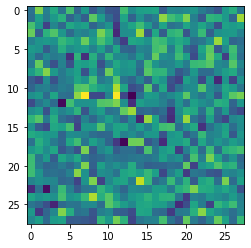

In [11]:
x_param = torch.nn.Parameter(x)
preds, p = net(x_param)

# calculate gradient of 6th output with respect to the input (param)
label_5_index = 6
label_5_pred = preds[0, label_5_index]
label_5_pred.backward()

grad_img = x_param.grad.view(28, 28)
plt.imshow(grad_img)

In [12]:
%%capture
! pip install pytorch-lightning-bolts --upgrade

In [13]:
from pl_bolts.callbacks.vision.confused_logit import ConfusedLogitCallback

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:343: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  f"Base `Callback.{hook}` hook signature h

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


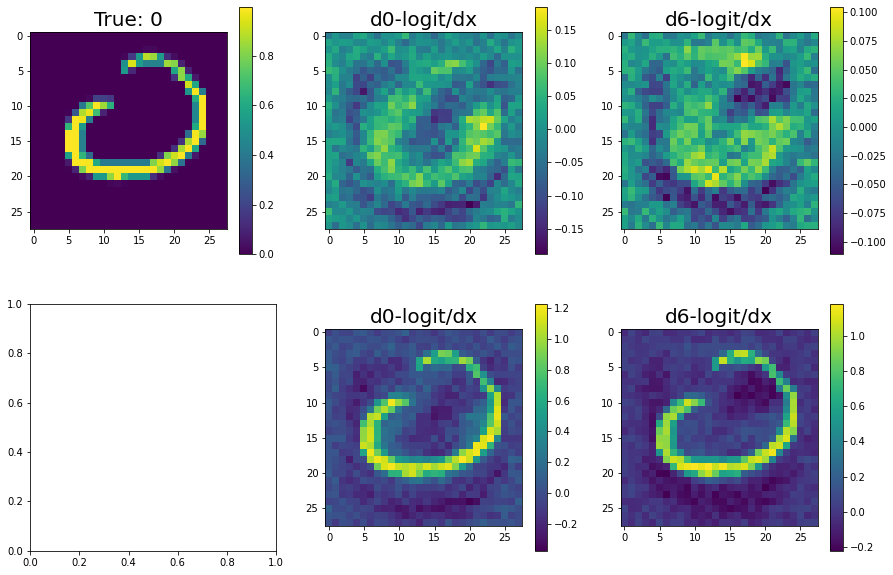

In [19]:
#from pl_bolts.callbacks.vision import ConfusedLogitCallback
from pl_bolts.callbacks.vision.confused_logit import ConfusedLogitCallback

class LitClassifier(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        #result = pl.TrainResult(loss)

        # enable the auto confused logit callback
        self.last_batch = batch
        self.last_logits = y_hat.detach()

        #result.log('train_loss', loss, on_epoch=True)
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        #result = pl.EvalResult(checkpoint_on=loss)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)

# train!
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [55000, 5000])
def main():
    model = LitClassifier()
    # cl = ConfusedLogitCallback(1)
    # cl.logging_batch_interval = 2
    confused_logit_callback = ConfusedLogitCallback(top_k=3, logging_batch_interval=1)
    trainer = Trainer(max_epochs=5, gpus=1, progress_bar_refresh_rate=10, callbacks=[confused_logit_callback])
    trainer.batch_idx=1
    trainer.fit(model, DataLoader(train, batch_size=64), DataLoader(val, batch_size=64))

main()